## naver_place 평점 감성 리뷰

In [1]:
import time
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt; t = Okt()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from nltk import Text
from wordcloud import WordCloud
from collections import Counter
from matplotlib import font_manager, rc
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### 데이터 로드

In [2]:
columns = ['name','loca','writer','review','point','emotion']
raw_datas = pd.read_csv('datas/naver_myplace_review.csv',names = columns)

#### train, test 나누기

In [3]:
target = raw_datas['emotion']
X_train, X_test, y_train, y_test = train_test_split(raw_datas, target, train_size=0.7, random_state =13,stratify = target)

#### 비율 확인
- 생각보다 비율이 너무 낮음

In [4]:
X_train.emotion.value_counts() / X_train.emotion.value_counts().sum() * 100

positive    86.829425
negative    13.170575
Name: emotion, dtype: float64

In [5]:
X_test.emotion.value_counts() / X_test.emotion.value_counts().sum() * 100

positive    86.81154
negative    13.18846
Name: emotion, dtype: float64

#### stopword 생성

In [6]:
# stop_words = pd.read_csv('datas/korean_stopwords.csv',names = ['korean'])
# stop_words = list(stop_words.korean)
# stop_words

#### 명사 분석 함수(wc 만들기용)

In [7]:
twitter = Okt()
def tw_tokenizer_nouns(text):
    tokens_ko = twitter.nouns(text)
    return tokens_ko

#### 명사 빈도 분석

In [8]:
nouns = []
for i in range(0,len(raw_datas['review'])):
    nouns.extend(tw_tokenizer_nouns(raw_datas['review'][i]))

In [9]:
wc = WordCloud(background_color = 'white', max_words = 2000)
wc = wc.generate(str(nouns))
wc.words_

{"맛'": 1.0,
 "분위기'": 0.400609756097561,
 "맛집'": 0.39634146341463417,
 "곳'": 0.36890243902439024,
 "빵'": 0.35,
 "정말'": 0.31890243902439025,
 "진짜'": 0.3103658536585366,
 "가격'": 0.26097560975609757,
 "카페'": 0.2548780487804878,
 "음식'": 0.24695121951219512,
 "커피'": 0.23414634146341465,
 "사람'": 0.2121951219512195,
 "좀'": 0.19573170731707318,
 "직원'": 0.1951219512195122,
 "더'": 0.1823170731707317,
 "것'": 0.18048780487804877,
 "메뉴'": 0.17926829268292682,
 "추천'": 0.17682926829268292,
 "때'": 0.16829268292682928,
 "수'": 0.16463414634146342,
 "최고'": 0.15426829268292683,
 "집'": 0.1524390243902439,
 "사장'": 0.14085365853658535,
 "생각'": 0.13048780487804879,
 "밥'": 0.12926829268292683,
 "파스타'": 0.12378048780487805,
 "양'": 0.12317073170731707,
 "주문'": 0.1225609756097561,
 "여기'": 0.12134146341463414,
 "조금'": 0.11646341463414635,
 "또'": 0.11463414634146342,
 "굿'": 0.11463414634146342,
 "그냥'": 0.11402439024390244,
 "정도'": 0.11097560975609756,
 "시간'": 0.10670731707317073,
 "뷰'": 0.10548780487804878,
 "서비스'":

In [10]:
ko = nltk.Text(nouns, name = 'naver_myplace_review')
print('전체 명사의 갯수 :',len(ko.tokens))
print('유니크한 명사의 갯수 :',len(set(ko.tokens)))
ko.vocab()

전체 명사의 갯수 : 65266
유니크한 명사의 갯수 : 6892


FreqDist({'맛': 2109, '분위기': 953, '빵': 823, '맛집': 814, '커피': 684, '곳': 653, '가격': 609, '카페': 595, '진짜': 542, '정말': 523, ...})

#### 한글 설정 및 빈도 그래프 그리기

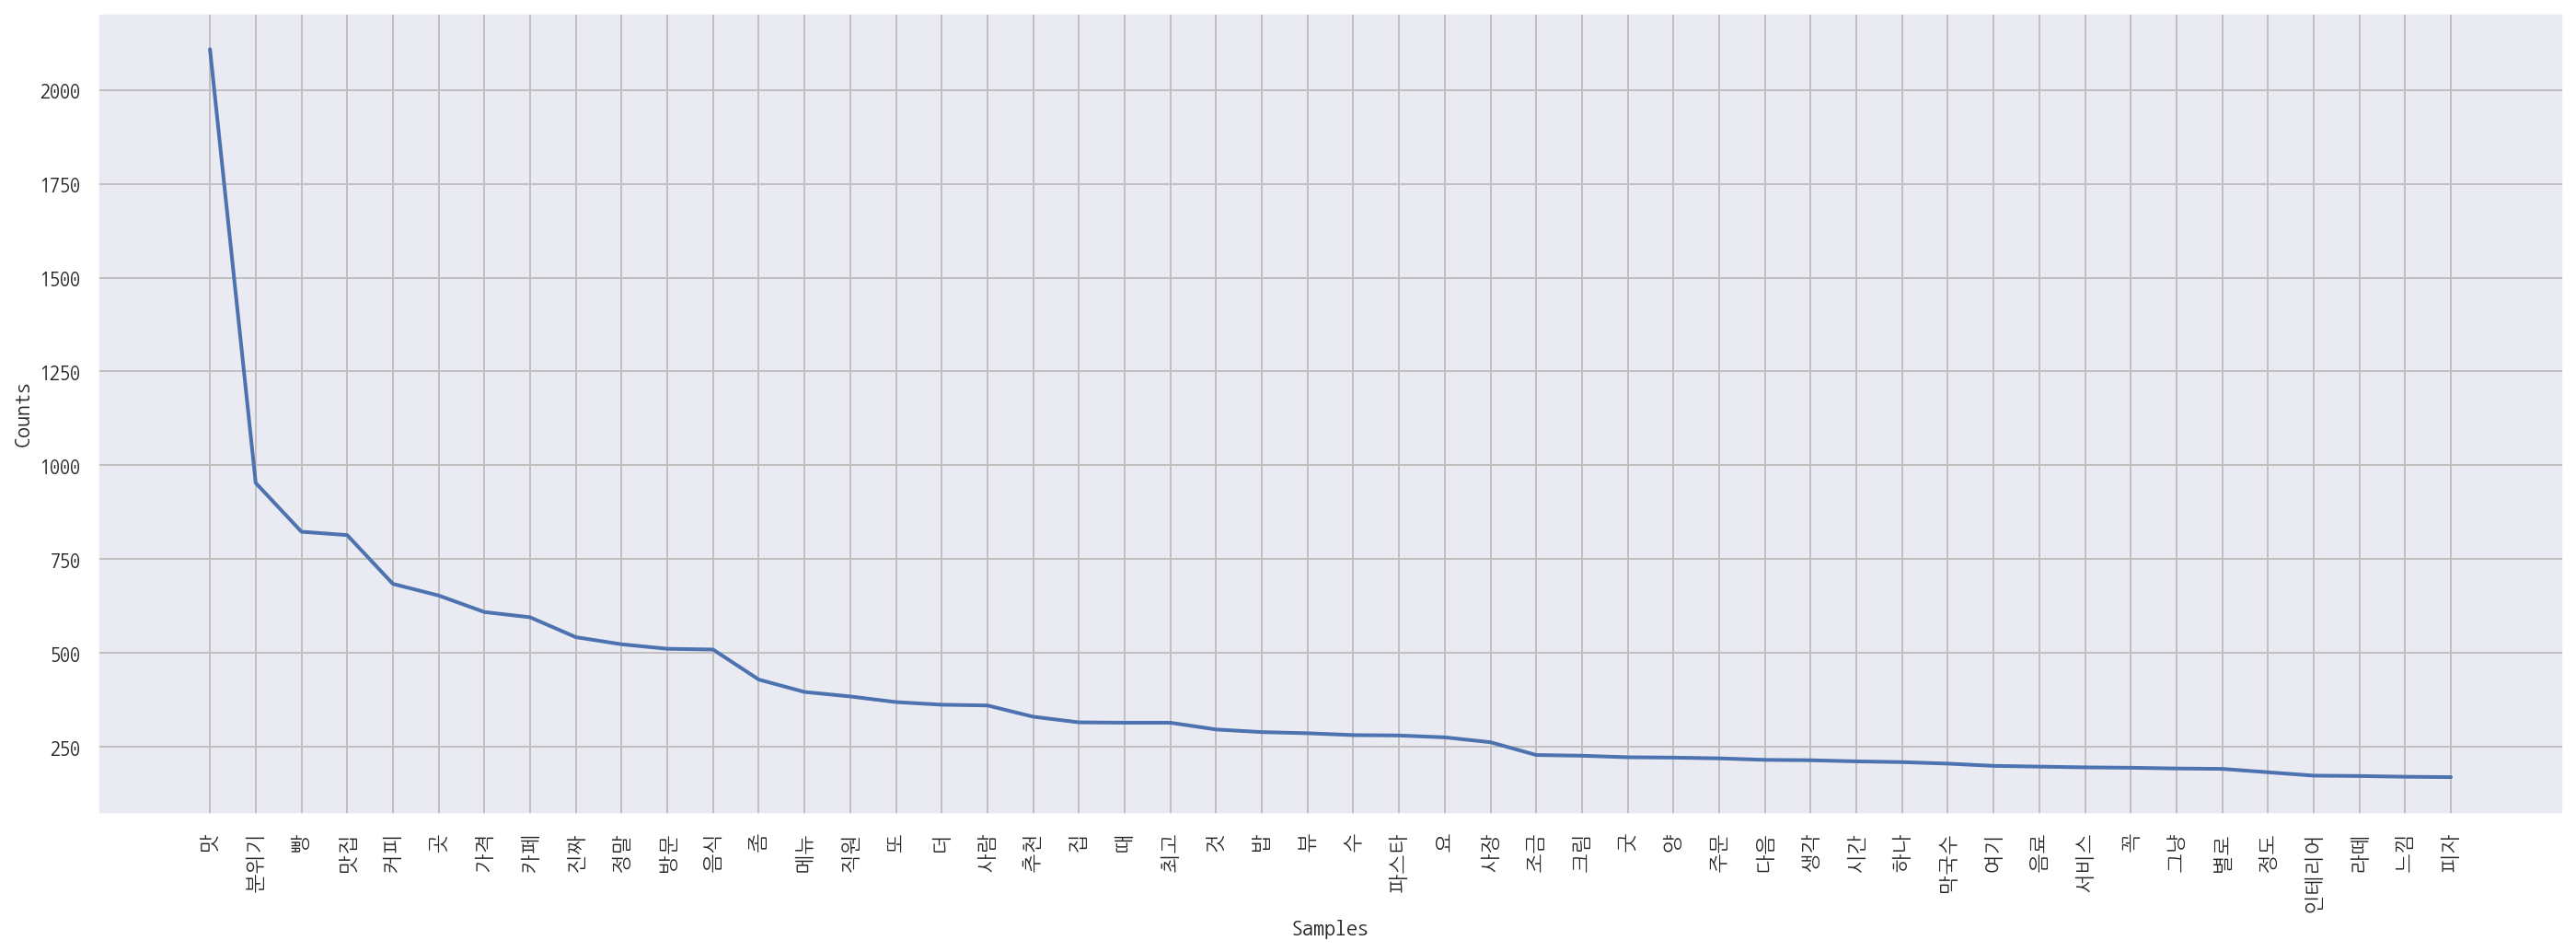

In [11]:
plt.rcParams['axes.unicode_minus'] = False

f_path = '/Users/hmkim/AppData/Local/Microsoft/Windows/Fonts/NanumGothicCoding.ttf'

font_name = font_manager.FontProperties(fname = f_path).get_name()
rc('font', family = font_name)

plt.figure(figsize=(24, 8))
ko.plot(50) # 상위 50개
plt.show()

#### wordcloud 만들기

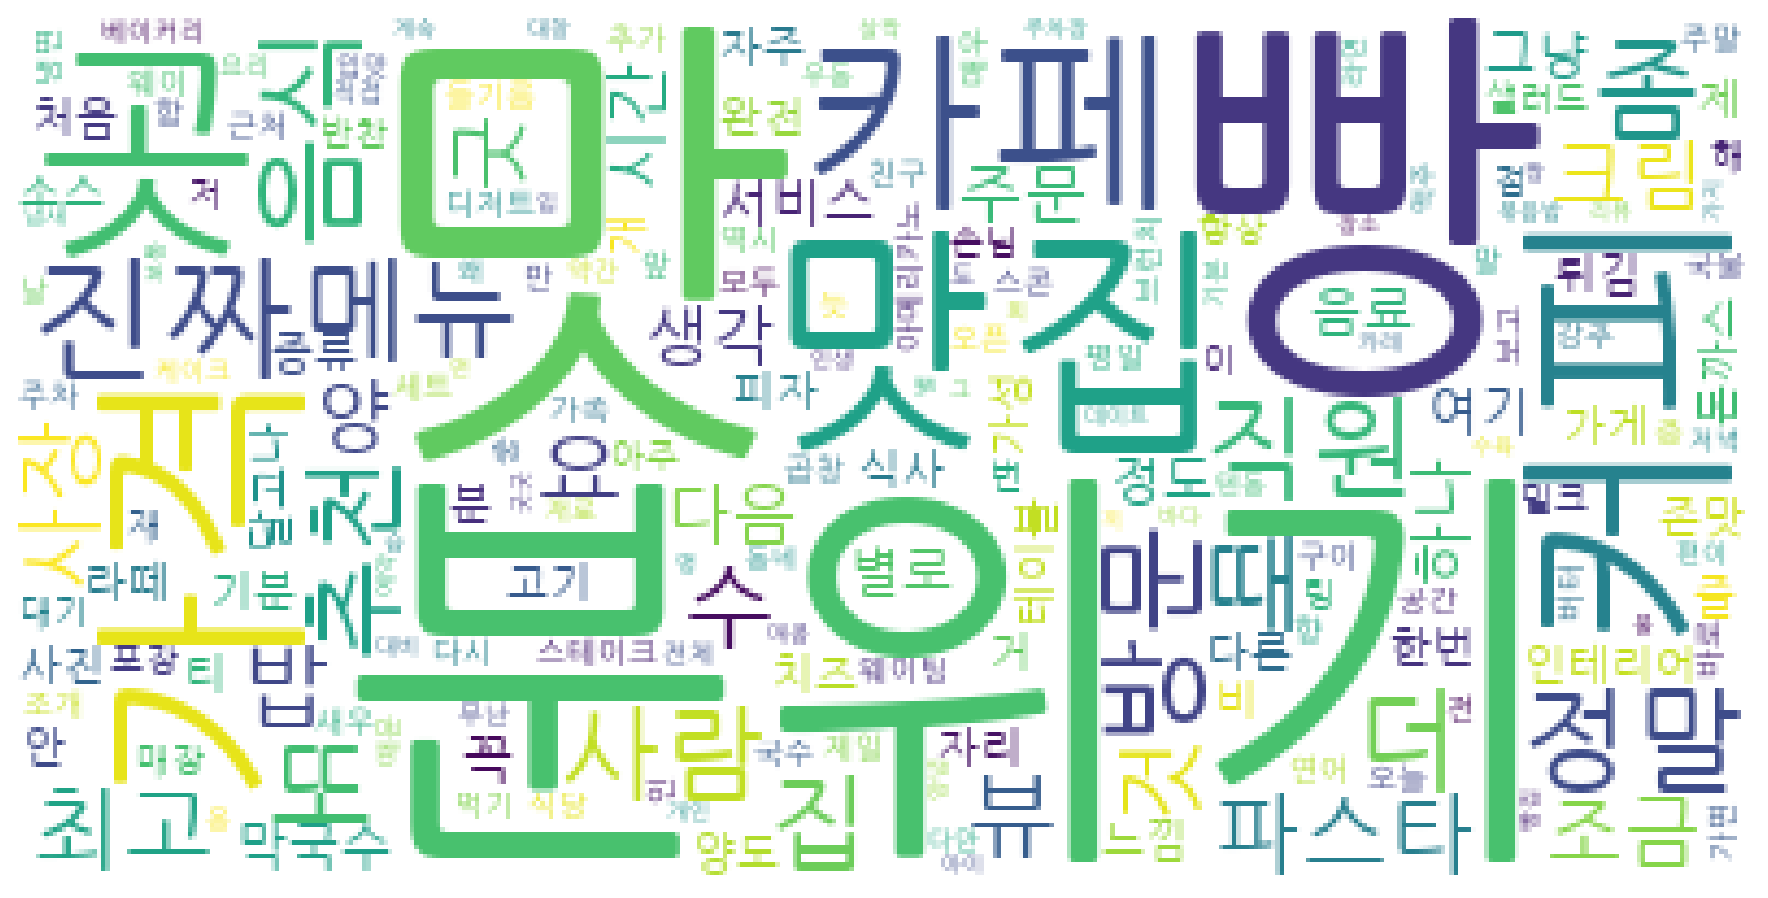

In [12]:
data = ko.vocab().most_common(5000)
wordcloud = WordCloud(font_path=f_path,
                      relative_scaling=0.2,
                      background_color='white',
                      ).generate_from_frequencies(dict(data))
plt.figure(figsize=(24, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### 형태소 분석 함수 (머신러닝 학습용)
- norm : 정규화
- stem : 어근화

In [15]:
twitter = Okt()
def tw_tokenizer(text):
    tokens_ko = twitter.morphs(text, norm=True)
    return tokens_ko

In [16]:
tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer,
                             ngram_range=(1, 2), min_df=3, max_df=0.9,)#,stop_words=stop_words
tfidf_vect.fit(X_train['review'])
tfidf_matrix_train = tfidf_vect.transform(X_train['review'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [17]:
print(len(tfidf_vect.get_feature_names()))
docs = tfidf_vect.get_feature_names()
docs

8181


['0',
 '0001',
 '0001 f',
 '1',
 '1 개',
 '1 도',
 '1 메뉴',
 '1 인',
 '1 인분',
 '1 층',
 '10',
 '100',
 '100 프로',
 '1000원',
 '10분',
 '10분 정도',
 '10시',
 '11',
 '11시',
 '12000원',
 '12시',
 '15',
 '15000원',
 '15분',
 '19',
 '1등',
 '1시',
 '1시간',
 '2',
 '2 개',
 '2 명',
 '2 번',
 '2 인',
 '2 인분',
 '2 층',
 '20',
 '200',
 '200 d',
 '2000원',
 '2020년',
 '20분',
 '23',
 '25분',
 '2시',
 '2시간',
 '2천원',
 '3',
 '3 개',
 '3 대',
 '3 명',
 '3 인',
 '3 인분',
 '3 층',
 '3000원',
 '30분',
 '30분 정도',
 '34',
 '35',
 '3년',
 '3만원',
 '3시',
 '3시 부터',
 '3월',
 '4',
 '4 개',
 '4 번',
 '4 인',
 '4 인분',
 '40분',
 '40분 정도',
 '4만원',
 '4시',
 '4시간',
 '5',
 '5 개',
 '5 점',
 '5 층',
 '50',
 '5000원',
 '500원',
 '5만원',
 '5시',
 '5천원',
 '6',
 '6000원',
 '6500원',
 '6시',
 '6천원',
 '7',
 '7시',
 '7천원',
 '8',
 '8시',
 '8천원',
 '90',
 '90 d',
 '9시',
 'a',
 'b',
 'd',
 'f',
 'f 90',
 'g',
 'good',
 'httpsmblognavercomblackgta',
 'jmt',
 'm',
 'sns',
 'sns 에서',
 'soso',
 'st',
 'u',
 'u 0001',
 'u 200',
 'ㄷㄷ',
 'ㅁ',
 'ㅅ',
 'ㅇㅇ',
 'ㅈ',
 'ㅋ',
 'ㅋㅋ',
 'ㅋㅋ 근데',
 'ㅋㅋㅋ',

#### 데이터 불균형 맞추기

In [18]:
smote = SMOTE(random_state = 13)
X_train_over, y_train_over = smote.fit_sample(tfidf_matrix_train, y_train)

In [19]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{'negative': 820, 'positive': 5406}

In [20]:
unique, counts = np.unique(y_train_over, return_counts=True)
dict(zip(unique, counts))

{'negative': 5406, 'positive': 5406}

In [21]:
tfidf_vect.get_feature_names()

['0',
 '0001',
 '0001 f',
 '1',
 '1 개',
 '1 도',
 '1 메뉴',
 '1 인',
 '1 인분',
 '1 층',
 '10',
 '100',
 '100 프로',
 '1000원',
 '10분',
 '10분 정도',
 '10시',
 '11',
 '11시',
 '12000원',
 '12시',
 '15',
 '15000원',
 '15분',
 '19',
 '1등',
 '1시',
 '1시간',
 '2',
 '2 개',
 '2 명',
 '2 번',
 '2 인',
 '2 인분',
 '2 층',
 '20',
 '200',
 '200 d',
 '2000원',
 '2020년',
 '20분',
 '23',
 '25분',
 '2시',
 '2시간',
 '2천원',
 '3',
 '3 개',
 '3 대',
 '3 명',
 '3 인',
 '3 인분',
 '3 층',
 '3000원',
 '30분',
 '30분 정도',
 '34',
 '35',
 '3년',
 '3만원',
 '3시',
 '3시 부터',
 '3월',
 '4',
 '4 개',
 '4 번',
 '4 인',
 '4 인분',
 '40분',
 '40분 정도',
 '4만원',
 '4시',
 '4시간',
 '5',
 '5 개',
 '5 점',
 '5 층',
 '50',
 '5000원',
 '500원',
 '5만원',
 '5시',
 '5천원',
 '6',
 '6000원',
 '6500원',
 '6시',
 '6천원',
 '7',
 '7시',
 '7천원',
 '8',
 '8시',
 '8천원',
 '90',
 '90 d',
 '9시',
 'a',
 'b',
 'd',
 'f',
 'f 90',
 'g',
 'good',
 'httpsmblognavercomblackgta',
 'jmt',
 'm',
 'sns',
 'sns 에서',
 'soso',
 'st',
 'u',
 'u 0001',
 'u 200',
 'ㄷㄷ',
 'ㅁ',
 'ㅅ',
 'ㅇㅇ',
 'ㅈ',
 'ㅋ',
 'ㅋㅋ',
 'ㅋㅋ 근데',
 'ㅋㅋㅋ',

#### 학습 및 검증

In [22]:
# lgbm
start_time = time.time()
lgbm_clf = LGBMClassifier(n_estimators = 400)
lgbm_clf.fit(X_train_over, y_train_over)
# lgbm_clf.fit(tfidf_matrix_train, y_train)
print('Fit time : ', time.time() - start_time)
skfold = StratifiedKFold(n_splits=5)
cross_val_score(lgbm_clf, X_train_over, y_train_over, scoring=None, cv=skfold)
# cross_val_score(lgbm_clf, tfidf_matrix_train, y_train, scoring=None, cv=skfold)

Fit time :  5.706697702407837


array([0.85067037, 0.91863153, 0.92368178, 0.92414431, 0.92414431])

In [23]:
# randomforest
start_time = time.time()
random_clf = RandomForestClassifier(random_state=13,max_depth=5)
random_clf.fit(X_train_over, y_train_over)
# random_clf.fit(tfidf_matrix_train, y_train)
print('Fit time : ', time.time() - start_time)
skfold = StratifiedKFold(n_splits=5)
cross_val_score(random_clf, X_train_over, y_train_over, scoring=None, cv=skfold)
# cross_val_score(random_clf, tfidf_matrix_train, y_train, scoring=None, cv=skfold)

Fit time :  0.31621360778808594


array([0.74757282, 0.75312067, 0.79370953, 0.78029602, 0.79278446])

In [24]:
# decisiontree
start_time = time.time()
tree_clf = DecisionTreeClassifier(random_state=13,max_depth=5)
tree_clf.fit(X_train_over, y_train_over)
# tree_clf.fit(tfidf_matrix_train, y_train)
print('Fit time : ', time.time() - start_time)
skfold = StratifiedKFold(n_splits=5)
cross_val_score(tree_clf, X_train_over, y_train_over, scoring=None, cv=skfold)
# cross_val_score(tree_clf, tfidf_matrix_train, y_train, scoring=None, cv=skfold)

Fit time :  0.11269807815551758


array([0.63569117, 0.65557097, 0.67021277, 0.6692877 , 0.66558742])

#### 테스트 어큐러시 확인

In [25]:
tfidf_matrix_test = tfidf_vect.transform(X_test['review'])
preds = lgbm_clf.predict(tfidf_matrix_test)
accuracy_score(y_test, preds)

0.849756463094792

In [26]:
tfidf_matrix_test = tfidf_vect.transform(X_test['review'])
preds = random_clf.predict(tfidf_matrix_test)
accuracy_score(y_test, preds)

0.8242787560884226

In [27]:
tfidf_matrix_test = tfidf_vect.transform(X_test['review'])
preds = tree_clf.predict(tfidf_matrix_test)
accuracy_score(y_test, preds)

0.7954289996253279

#### 실제 문장 넣고 확인

In [28]:
X_test[['review','emotion']].iloc[333]

review     옆에 맛나 식당이 재료가 소진되어서 주변에 있는 장승포식당에 들렀는데 맛나식당은 1...
emotion                                             negative
Name: 6307, dtype: object

In [29]:
lgbm_clf.predict(tfidf_vect.transform([X_test['review'][6307]]))

array(['positive'], dtype=object)

In [30]:
random_clf.predict(tfidf_vect.transform([X_test['review'][6307]]))

array(['negative'], dtype=object)

In [31]:
tree_clf.predict(tfidf_vect.transform([X_test['review'][6307]]))

array(['negative'], dtype=object)

#### 감성 분류 적용

In [32]:
word = '별로에요'
print(f'"{word}"는 lgbm에서',lgbm_clf.predict(tfidf_vect.transform([word])))
print(f'"{word}"는 random_forest에서',random_clf.predict(tfidf_vect.transform([word])))
print(f'"{word}"는 decisiontree에서',tree_clf.predict(tfidf_vect.transform([word])))

"별로에요"는 lgbm에서 ['negative']
"별로에요"는 random_forest에서 ['positive']
"별로에요"는 decisiontree에서 ['negative']


In [33]:
word = '싫어요'
print(f'"{word}"는 lgbm에서',lgbm_clf.predict(tfidf_vect.transform([word])))
print(f'"{word}"는 random_forest에서',random_clf.predict(tfidf_vect.transform([word])))
print(f'"{word}"는 decisiontree에서',tree_clf.predict(tfidf_vect.transform([word])))

"싫어요"는 lgbm에서 ['negative']
"싫어요"는 random_forest에서 ['positive']
"싫어요"는 decisiontree에서 ['positive']


In [34]:
word = '맛없어요'
print(f'"{word}"는 lgbm에서',lgbm_clf.predict(tfidf_vect.transform([word])))
print(f'"{word}"는 random_forest에서',random_clf.predict(tfidf_vect.transform([word])))
print(f'"{word}"는 decisiontree에서',tree_clf.predict(tfidf_vect.transform([word])))

"맛없어요"는 lgbm에서 ['negative']
"맛없어요"는 random_forest에서 ['positive']
"맛없어요"는 decisiontree에서 ['positive']


In [35]:
word = '불친절 해요'
print(f'"{word}"는 lgbm에서',lgbm_clf.predict(tfidf_vect.transform([word])))
print(f'"{word}"는 random_forest에서',random_clf.predict(tfidf_vect.transform([word])))
print(f'"{word}"는 decisiontree에서',tree_clf.predict(tfidf_vect.transform([word])))

"불친절 해요"는 lgbm에서 ['negative']
"불친절 해요"는 random_forest에서 ['negative']
"불친절 해요"는 decisiontree에서 ['positive']


In [36]:
word = '친절 합니다'
print(f'"{word}"는 lgbm에서',lgbm_clf.predict(tfidf_vect.transform([word])))
print(f'"{word}"는 random_forest에서',random_clf.predict(tfidf_vect.transform([word])))
print(f'"{word}"는 decisiontree에서',tree_clf.predict(tfidf_vect.transform([word])))

"친절 합니다"는 lgbm에서 ['positive']
"친절 합니다"는 random_forest에서 ['positive']
"친절 합니다"는 decisiontree에서 ['positive']


In [37]:
word = '맛은 있지만 비싸요'
print(f'"{word}"는 lgbm에서',lgbm_clf.predict(tfidf_vect.transform([word])))
print(f'"{word}"는 random_forest에서',random_clf.predict(tfidf_vect.transform([word])))
print(f'"{word}"는 decisiontree에서',tree_clf.predict(tfidf_vect.transform([word])))

"맛은 있지만 비싸요"는 lgbm에서 ['negative']
"맛은 있지만 비싸요"는 random_forest에서 ['negative']
"맛은 있지만 비싸요"는 decisiontree에서 ['negative']


In [38]:
word = '더러워요'
print(f'"{word}"는 lgbm에서',lgbm_clf.predict(tfidf_vect.transform([word])))
print(f'"{word}"는 random_forest에서',random_clf.predict(tfidf_vect.transform([word])))
print(f'"{word}"는 decisiontree에서',tree_clf.predict(tfidf_vect.transform([word])))

"더러워요"는 lgbm에서 ['negative']
"더러워요"는 random_forest에서 ['positive']
"더러워요"는 decisiontree에서 ['positive']
